In [354]:
import sys
sys.path.append(r"C:\Users\acostamendoza\projects\distance-project")
from path_setup import setup_project_path
setup_project_path()

import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from src.utils import setup_plot_style, import_vars_from_matlab
from path_setup import setup_project_path
from src.ActivityPipelines import ActivityLoader
from src.DistanceProject import DistanceAnalysis, create_new_result_dir
from src.DistancePlots import plot_repeats, plot_trials, plot_raw_traces, plot_trials_ordered, plot_reliability_distribution, plot_trials_ordered_2, plot_boxplot, plot_RF_vs_modulation
import os
from scipy.stats import f_oneway, ttest_ind

%load_ext autoreload
%autoreload 2

colors = setup_plot_style()

data_dir = r'D:/data-distance-coding-project/processed-data'
session = r'250313_SAM033_gratings-full'

session_path = os.path.join(data_dir, session)
results_path = create_new_result_dir(session_path, r'results')
stimulus_path = os.path.join(session_path, r'stimulus')
activity_path = os.path.join(session_path, r'suite2p\plane0')

# check files inside stimulus_path
filelist = [file for file in os.listdir(stimulus_path) if file.endswith(("_stimulus.mat"))]
if len(filelist) == 0:
    # raise error
    raise Exception('No stimulus file found')
elif len(filelist) > 1:
    raise Exception('More than one stimulus file found')
else:
    print('Stimulus file found')

container = io.loadmat(stimulus_path + '/' + str(filelist[0]))

D = ActivityLoader(session_path)
# D.dFF = (D.dFF - np.mean(D.dFF, axis=1)[:, np.newaxis]) / np.std(D.dFF, axis=1)[:, np.newaxis]
frames_time = D.frames_time

pre_time_start = []
on_time_start = []
on_time_end = []
orientation_sequence = []

field_names = import_vars_from_matlab(container, 'stim_data', locals())

list_orientations = np.unique(orientation_sequence)
list_orientations.sort()

print(field_names)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Directory results already exists
Stimulus file found
('parameters', 'pre_time_start', 'on_time_start', 'orientation_sequence', 'on_time_end')


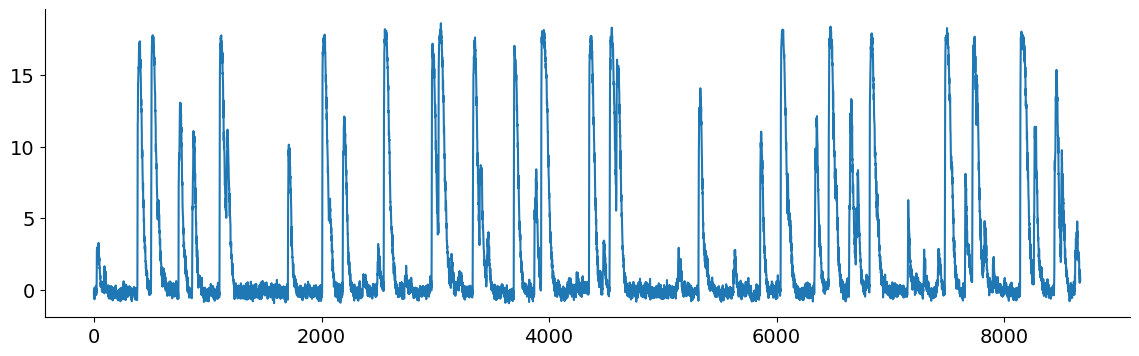

In [355]:
plt.figure(figsize=(14, 4))
cell = np.where(D.suite2p_id == 0)[0][0]
plt.plot(D.dFF[cell].T)
plt.show()

In [295]:
def get_on_frames(repeat):

    trial_start = 1000*on_time_start[repeat]
    trial_end = 1000*on_time_end[repeat]

    return (frames_time > trial_start) & (frames_time < trial_end)

def get_off_frames(repeat):

    trial_start = 1000*pre_time_start[repeat]
    trial_end = 1000*on_time_start[repeat]

    return (frames_time > trial_start) & (frames_time < trial_end)

def get_trace(cell, repeat, on_frames=True):

    if on_frames:
        frames = get_on_frames(repeat)
    else:
        frames = get_off_frames(repeat)

    trace = D.dFF[cell, frames]

    return trace[:20]

In [296]:
def plot_stimulus_response(cell, fig_path=None, n_repeats=10):
    """
    Plot the stimulus response for a given cell.
    
    Parameters:
    -----------
    fig_path : str, optional
        Path to save the figure. If provided, the figure will be saved.
    n_repeats : int or list, optional
        Number of repeats to plot or range of repeats [start, end] to plot.
        Default is 10 (plots first 10 repeats).
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object.
    """
    fig = plt.figure(figsize=(14,4))

    # Handle n_repeats input
    if isinstance(n_repeats, (list, tuple)) and len(n_repeats) == 2:
        repeats = np.arange(n_repeats[0], n_repeats[1])
    else:
        repeats = np.arange(n_repeats)

    # Get time range for selected repeats
    repeat_start = on_time_start[repeats[0]]*1000
    repeat_end = on_time_end[repeats[-1]]*1000
    repeats_frames = (frames_time > repeat_start) & (frames_time < repeat_end)

    # Create main plot
    ax = plt.subplot2grid((1, 10), (0, 0), colspan=9)
    ax.plot(frames_time[repeats_frames], D.dFF[cell,repeats_frames], lw=1.5, color='black')

    # Create orientation color mapping
    cmap = plt.cm.hsv
    colors = {orient: cmap(i/len(list_orientations)) for i, orient in enumerate(list_orientations)}

    # Highlight stimulus periods
    for rep in repeats:
        rep_start = 1000*on_time_start[rep]
        rep_end = 1000*on_time_end[rep]
        orientation = orientation_sequence[rep]
        ax.axvspan(rep_start, rep_end, color=colors[orientation], alpha=0.3)

    # Create circular colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.07, 0.5], polar=True)
    orientation_angles = np.linspace(0, 2*np.pi, len(list_orientations), endpoint=False)
    
    # Add orientation segments to colorbar
    for i, orient in enumerate(list_orientations):
        angle_start = orientation_angles[i]
        angle_end = orientation_angles[(i+1) % len(list_orientations)]
        cbar_ax.fill_between([angle_start, angle_end], 0, 1, color=colors[orient], alpha=0.3)
    
    # Remove ticks and add key orientation labels
    cbar_ax.set_yticks([])
    cbar_ax.set_xticks([])
    
    # Add only key orientation labels
    key_orientations = [0, 45, 90, 135]
    for orient in key_orientations:
        if orient in list_orientations:
            idx = np.where(list_orientations == orient)[0][0]
            angle = orientation_angles[idx]
            cbar_ax.text(angle, 1.2, f"{int(orient)}°", 
                        ha='center', va='center', rotation=np.degrees(angle)-90)
    
    cbar_ax.set_title('Orientation', pad=20)
    
    # Set plot labels
    ax.set_title('Orientation Tuning, cell' + str(D.suite2p_id[cell]))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Response (dFF)')
    plt.tight_layout()

    # Save if path provided
    if fig_path is not None:
        plt.savefig(fig_path + '/cell_' + str(D.suite2p_id[cell]) + '.png')
        plt.close()
        
    return fig

[210  90  30 120 330 300 150  60   0 270]


C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_19640\286275340.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


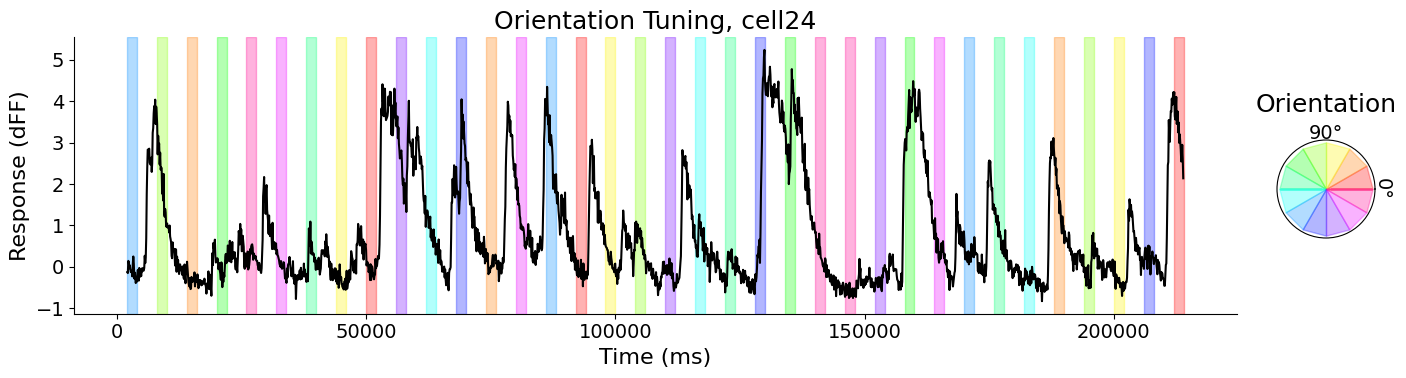

In [343]:
cell_to_show = np.where(D.suite2p_id == 24)[0][0]
fig = plot_stimulus_response(cell=cell_to_show, n_repeats=36)
print(orientation_sequence[:10])

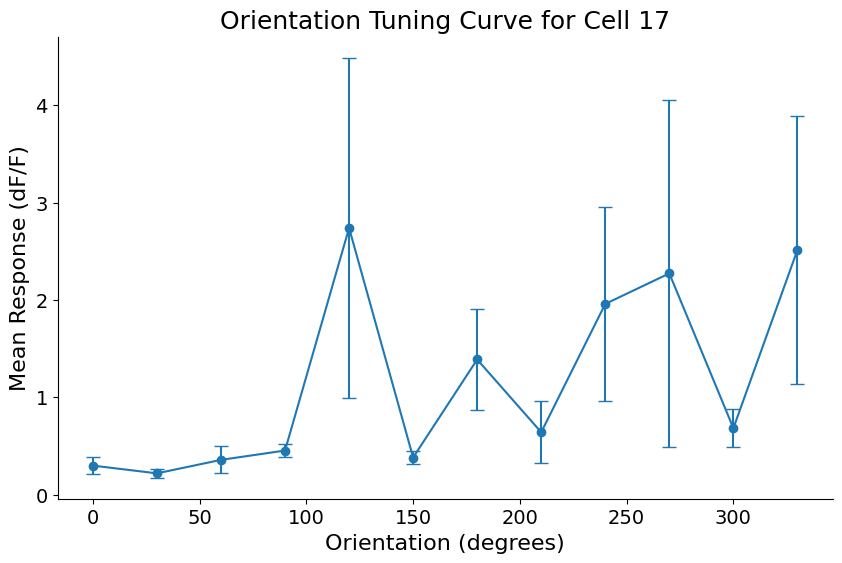

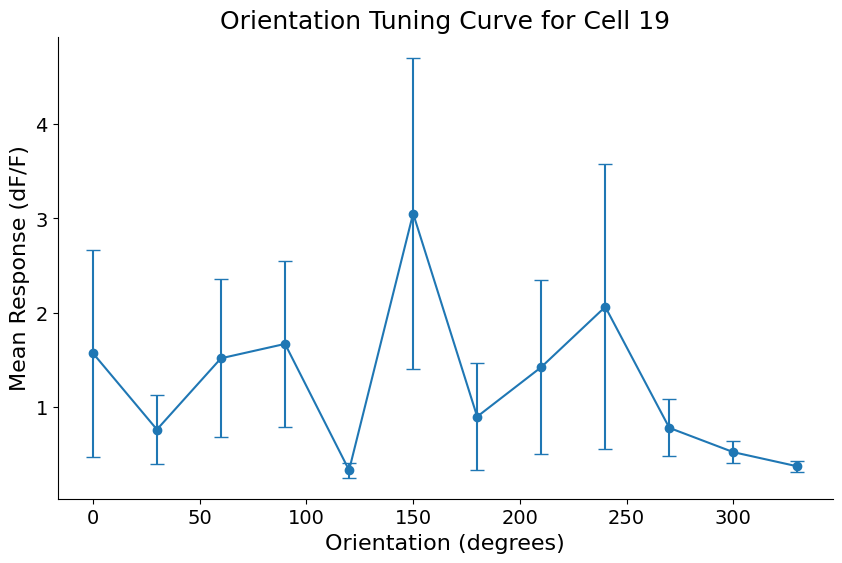

In [348]:
from scipy.ndimage import gaussian_filter1d

def get_orientation_response(cell, orientation):
    """Get the trial responses for a specific orientation."""
    # select only repeats that have the same orientation
    repeats = np.where(orientation_sequence == orientation)[0]

    trial_responses = []
    for repeat in repeats:
        trace = get_trace(cell, repeat)
        # make a running average of the trace
        trace = gaussian_filter1d(trace, sigma=1)
        trial_responses.append(np.max(trace))

    return trial_responses


def get_tuning_curve(cell):
    """Get the orientation tuning curve for a given cell.
    
    Parameters:
    -----------
    cell : int
        The cell index to analyze
        
    Returns:
    --------
    orientations : numpy.ndarray
        Sorted array of unique orientations
    mean_responses : numpy.ndarray
        Mean response for each orientation
    sem_responses : numpy.ndarray
        Standard error of the mean for each orientation
    """

    # Collect mean responses for each orientation
    mean_responses = []
    sem_responses = []
    
    for orientation in list_orientations:
        trial_responses = get_orientation_response(cell, orientation)
        mean_responses.append(np.mean(trial_responses))
        sem_responses.append(np.std(trial_responses) / np.sqrt(len(trial_responses)))
    
    return np.array(mean_responses), np.array(sem_responses)


def plot_tuning_curve(cell, save_path=None):
    """
    Plot the orientation tuning curve for a cell.

    Parameters:
    -----------
    orientations : numpy.ndarray
    Array of orientation values in degrees
    mean_responses : numpy.ndarray
    Mean response for each orientation
    sem_responses : numpy.ndarray
    Standard error of the mean for each orientation
    cell_id : int
    ID of the cell
    save_path : str, optional
    Path to save the figure. If None, the figure is not saved.
    """
    mean_responses, sem_responses = get_tuning_curve(cell)

    plt.figure(figsize=(10, 6))
    plt.errorbar(list_orientations, mean_responses, yerr=sem_responses, marker='o', linestyle='-', capsize=5)
    plt.xlabel('Orientation (degrees)')
    plt.ylabel('Mean Response (dF/F)')
    plt.title(f'Orientation Tuning Curve for Cell {D.suite2p_id[cell]}')
    if save_path is not None:
        plt.savefig(save_path + f'cell_{D.suite2p_id[cell]}.png')
        plt.close()


# Example of using the tuning curve function
cell_to_show = np.where(D.suite2p_id == 17)[0][0]
mean_responses, sem_responses = get_tuning_curve(cell = cell_to_show)
plot_tuning_curve(cell = cell_to_show)

cell_to_show = np.where(D.suite2p_id == 19)[0][0]
mean_responses, sem_responses = get_tuning_curve(cell = cell_to_show)
plot_tuning_curve(cell = cell_to_show)

In [349]:
# for all cells, plot the tuning curve
fig_path = create_new_result_dir(results_path, r'tuning-curves')
for cell in range(np.shape(D.dFF)[0]):
    # Plot and save the tuning curve for the current cell
    plot_tuning_curve(cell, 
                      save_path=fig_path + f'/cell_{D.suite2p_id[cell]}.png')

Directory tuning-curves already exists


# Analyzing if cells are visual responsive

In [299]:
def is_cell_responsive(cell, plot=False):
    """
    Determines if a cell is significantly more active during on times than off times.
    
    Args:
        cell: Cell index to analyze
        plot: Whether to plot the boxplot of on vs off activity
        
    Returns:
        bool: True if cell is significantly more active during on times
    """
    on_mean = []
    off_mean = []
    for repeat in range(len(orientation_sequence)):
        on_trace = get_trace(cell, repeat)
        off_trace = get_trace(cell, repeat, on_frames=False)
        on_mean.append(np.mean(on_trace))
        off_mean.append(np.mean(off_trace))


    # Perform t-test
    _, p_value = ttest_ind(on_mean, off_mean)
    
    if plot:
        # Create boxplot
        fig, ax = plt.subplots(figsize=(6, 4))
        data = [on_mean, off_mean]
        bp = ax.boxplot(data, patch_artist=True, showfliers=False, labels=['ON', 'OFF'])
        
        # Customize boxplot colors and line thickness
        colors = ['blue', 'gray']
        for i, (box, whisker, cap, median) in enumerate(zip(bp['boxes'], bp['whiskers'][::2], bp['caps'][::2], bp['medians'])):
            box.set_facecolor('none')
            box.set_linewidth(2)
            box.set_edgecolor(colors[i])
            
            whisker.set_linewidth(2)
            whisker.set_color(colors[i])
            
            bp['whiskers'][i*2+1].set_linewidth(2)
            bp['whiskers'][i*2+1].set_color(colors[i])
            
            cap.set_linewidth(2)
            cap.set_color(colors[i])
            
            bp['caps'][i*2+1].set_linewidth(2)
            bp['caps'][i*2+1].set_color(colors[i])
            
            median.set_linewidth(2)
            median.set_color(colors[i])

        # add p-value annotation in the title
        ax.set_title(f'Cell {D.suite2p_id[cell]} Activity (p={p_value:.3f})')
    
        ax.set_ylabel('dFF')
        plt.tight_layout()
        
    # Check if mean on activity is greater and p-value significant
    return (np.mean(on_mean) > np.mean(off_mean)) and (p_value < 0.05)

In [356]:
responsive_cells = []
unresponsive_cells = []
for cell in range(np.shape(D.dFF)[0]):
    if is_cell_responsive(cell, plot=False):
        responsive_cells.append(cell)
    else:
        unresponsive_cells.append(cell)

# responsive_path = create_new_result_dir(results_path, r'responsive-cells')
# for cell in responsive_cells:
#     plot_stimulus_response(cell, fig_path=responsive_path, n_repeats=36)

# unresponsive_path = create_new_result_dir(results_path, r'unresponsive-cells')
# for cell in unresponsive_cells:
#     plot_stimulus_response(cell, fig_path=unresponsive_path, n_repeats=36)

Found 558 responsive to on times out of 1282 total cells


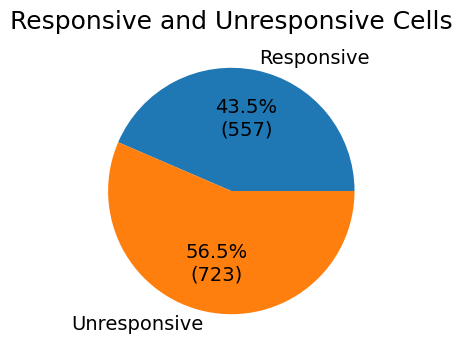

In [357]:
print(f"Found {len(responsive_cells)} responsive to on times out of {D.dFF.shape[0]} total cells")

# make a pie plot showing the percentage and number of responsive and unresponsive cells
fig, ax = plt.subplots(figsize=(6, 4))
responsive_count = len(responsive_cells)
unresponsive_count = len(unresponsive_cells)
ax.pie([responsive_count, unresponsive_count], 
       labels=['Responsive', 'Unresponsive'], 
       autopct=lambda p: f'{p:.1f}%\n({int(p*sum([responsive_count, unresponsive_count])/100)})')
ax.set_title('Responsive and Unresponsive Cells')
plt.show()

# Measure tuning

In [202]:
responsive_orientation_path = create_new_result_dir(results_path, r'responsive-cells-orientation')
print(responsive_orientation_path)
for cell in responsive_cells:
    print(f"Plotting tuning curve for cell {D.suite2p_id[cell]}", end="\r")
    plot_tuning_curve(cell, save_path=responsive_orientation_path)


Directory responsive-cells-orientation already exists
D:/data-distance-coding-project/processed-data\250313_SAM033_gratings-full\results\responsive-cells-orientation


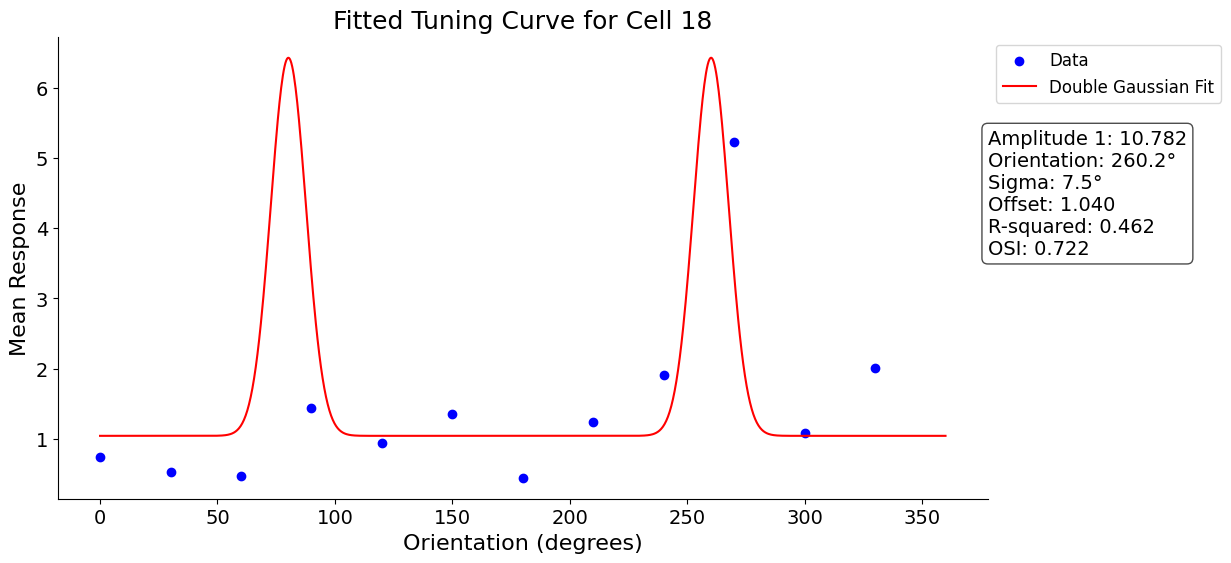

In [302]:
cell_to_show = np.where(D.suite2p_id == 17)[0][0]
mean_responses, _ = get_tuning_curve(cell_to_show)

# Define a double Gaussian function (two peaks 180 degrees apart)
def double_gaussian(x, amp, orientation, sigma, offset):
    gaussian = offset + amp/2 * (np.exp(-(x - orientation)**2 / (2 * sigma**2)) + 
                                 np.exp(-(x - (orientation + 180) % 360)**2 / (2 * sigma**2)))
    return gaussian 

# Function to fit a double Gaussian to orientation tuning data for a given cell
def fit_double_gaussian(cell):
    mean_responses, _ = get_tuning_curve(cell=cell)
    
    # Initial parameter guesses
    initial_guess = [
        np.max(mean_responses),     # amp - using full amplitude for better initial fit
        list_orientations[np.argmax(mean_responses)],  # preferred orientation
        20,                         # sigma - width of peak around 20 degrees
        np.min(mean_responses)      # offset
    ]
    
    # Fit the double Gaussian to the data
    from scipy.optimize import curve_fit
    params, _ = curve_fit(double_gaussian, list_orientations, mean_responses, p0=initial_guess, maxfev=10000)
    
    # Calculate quality of fit metrics
    y_pred = double_gaussian(list_orientations, *params)
    # compute r squared for the fit
    ss_total = np.sum((mean_responses - np.mean(mean_responses))**2)
    ss_residual = np.sum((mean_responses - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)
    
    return params, r_squared

# Function to calculate orientation and direction selectivity indices
def calculate_selectivity_indices(preferred_orientation, params):
    """
    Calculate orientation selectivity index (OSI) and direction selectivity index (DSI)
    based on the fitted double Gaussian parameters.
    
    Args:
        preferred_orientation: The preferred orientation from the fit (in degrees)
        params: Parameters from the double Gaussian fit [amp, orientation, sigma, offset]
    
    Returns:
        osi: Orientation Selectivity Index
        dsi: Direction Selectivity Index
    """
    amp, orientation, sigma, offset = params
    
    # Calculate responses at preferred orientation and orthogonal orientation
    resp_preferred = double_gaussian(preferred_orientation, *params)
    resp_orthogonal = double_gaussian((preferred_orientation + 90) % 360, *params)
    
    # Calculate OSI: (Rpref - Rorth) / (Rpref + Rorth)
    osi = (resp_preferred - resp_orthogonal) / (resp_preferred + resp_orthogonal)
    
    # Calculate responses at preferred direction and opposite direction
    resp_preferred_dir = double_gaussian(preferred_orientation, *params)
    resp_opposite_dir = double_gaussian((preferred_orientation + 180) % 360, *params)
    
    return osi

# Get the parameters for the current cell
params, rmse = fit_double_gaussian(cell_to_show)

# Function to plot the tuning curve with the double Gaussian fit
def plot_double_gaussian_fit(cell, fig_path=None):
    
    mean_responses, _ = get_tuning_curve(cell)
    params, r_squared = fit_double_gaussian(cell)
    
    # Extract parameters for display
    amp, orientation, sigma, offset = params
    
    # Calculate selectivity indices using a separate function
    osi = calculate_selectivity_indices(orientation, params)
    
    plt.figure(figsize=(12, 6))  # Increase the width to accommodate the text box
    plt.scatter(list_orientations, mean_responses, color='blue', label='Data')
    x_fit = np.linspace(0, 360, 1000)
    y_fit = double_gaussian(x_fit, *params)
    plt.plot(x_fit, y_fit, 'r-', label='Double Gaussian Fit')
    plt.xlabel('Orientation (degrees)')
    plt.ylabel('Mean Response')
    plt.title(f'Fitted Tuning Curve for Cell {D.suite2p_id[cell]}')
    
    # Add text with parameters and error
    param_text = (f'Amplitude 1: {amp:.3f}\nOrientation: {orientation:.1f}°\n'
                 f'Sigma: {sigma:.1f}°\nOffset: {offset:.3f}\n'
                 f'R-squared: {r_squared:.3f}\nOSI: {osi:.3f}')
    plt.annotate(param_text, xy=(1.0, 0.8), xycoords='axes fraction', 
                 va='top', ha='left', bbox=dict(boxstyle='round', fc='white', alpha=0.7))
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    if fig_path is not None:
        plt.savefig(fig_path + f'/cell_{D.suite2p_id[cell]}.png', bbox_inches='tight')  # Use bbox_inches='tight' to ensure everything fits
        plt.close()
    else:
        plt.show()

# Plot the results for the current cell
plot_double_gaussian_fit(cell=18)

In [268]:
# for all cells, plot the double gaussian fit
fig_path = create_new_result_dir(results_path, r'double-gaussian-fit')
for cell in responsive_cells:
    plot_double_gaussian_fit(cell, fig_path=fig_path)

Directory double-gaussian-fit already exists


C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_19640\525452846.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(double_gaussian, list_orientations, mean_responses, p0=initial_guess, maxfev=10000)


In [ ]:
# Function to get all properties for a selected cell
def get_cell_properties(cell):
    """
    Creates a dictionary with all properties for a selected cell including:
    - tuning curve (mean responses)
    - orientations
    - fit parameters
    - r-squared value
    - orientation selectivity index (OSI)
    
    Parameters:
    -----------
    cell : int
        Cell index
        
    Returns:
    --------
    dict
        Dictionary containing all cell properties
    """
    # Get tuning curve data
    mean_responses, sem_responses = get_tuning_curve(cell)
    
    # Get fit parameters and r-squared
    params, r_squared = fit_double_gaussian(cell)
    
    # Extract individual parameters
    amp, orientation, sigma, offset = params
    
    # Calculate OSI
    osi = calculate_selectivity_indices(orientation, params)
    
    # Create dictionary with all properties
    cell_properties = {
        'cell_id': D.suite2p_id[cell],
        'orientations': list_orientations,
        'mean_responses': mean_responses,
        'sem_responses': sem_responses,
        'fit_params': {
            'amplitude': amp,
            'preferred_orientation': orientation,
            'sigma': sigma,
            'offset': offset
        },
        'r_squared': r_squared,
        'osi': osi
    }
    
    return cell_properties



In [358]:
# now make a dataframe with all the properties for all the cells
import pandas as pd         
cell_properties_df = pd.DataFrame([get_cell_properties(cell) for cell in responsive_cells])
# save the dataframe to a csv file
cell_properties_df.to_csv(os.path.join(results_path, r'cell_properties.csv'), index=False)

C:\Users\acostamendoza\AppData\Local\Temp\ipykernel_19640\525452846.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(double_gaussian, list_orientations, mean_responses, p0=initial_guess, maxfev=10000)


In [359]:
# show dataframe visually
cell_properties_df.head()


,cell_id,orientations,mean_responses,sem_responses,fit_params,r_squared,osi
0,0,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.22729567, 1.0227764, 1.9671447, 13.1352, 17...","[0.07770721934417235, 0.6675572743619858, 0.83...","{'amplitude': 36.94552913752865, 'preferred_or...",0.981797,0.890079
1,3,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.54742056, 0.75358737, 0.6046846, 2.4880238,...","[0.09252028769906882, 0.3712773626507115, 0.24...","{'amplitude': 48.36839498785047, 'preferred_or...",0.980376,0.933306
2,4,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[1.0865631, 0.47178906, 0.59248006, 0.76943624...","[0.3091964245667412, 0.030504722011316952, 0.1...","{'amplitude': 110.28748141729643, 'preferred_o...",0.975539,0.976120
3,6,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.20474167, 0.52106726, 0.60240227, 2.187716,...","[0.16947247786230488, 0.5048870449682481, 0.32...","{'amplitude': 15.856119524939968, 'preferred_o...",0.950268,0.792480
4,8,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[1.2192856, 3.1390345, 13.45334, 13.533821, 8....","[0.4254739108571731, 0.9100285153136443, 0.176...","{'amplitude': 28.386542493760448, 'preferred_o...",0.959009,0.847088


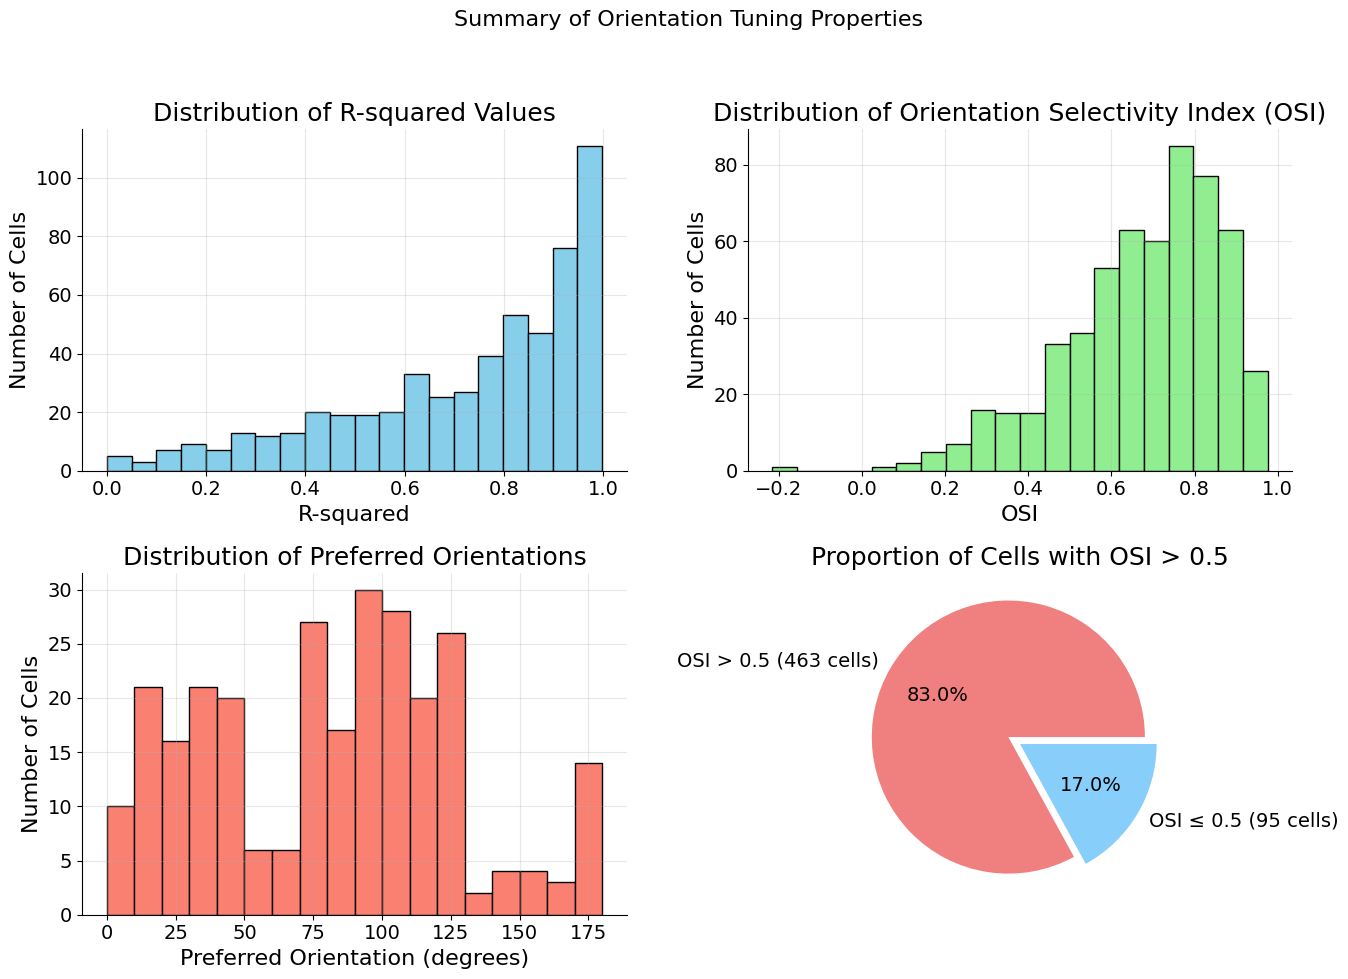

Total number of cells: 558
Number of cells with OSI > 0.5: 463 (83.0%)
Mean OSI: 0.676 ± 0.186 (SD)
Mean R-squared: 0.727 ± 0.244 (SD)
Mean preferred orientation: 172.3° ± 106.5° (SD)


In [360]:
# Set up a figure with multiple subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Summary of Orientation Tuning Properties', fontsize=16)

# 1. Histogram of R-squared (goodness of fit)
axs[0, 0].hist(cell_properties_df['r_squared'], bins=20, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribution of R-squared Values')
axs[0, 0].set_xlabel('R-squared')
axs[0, 0].set_ylabel('Number of Cells')
axs[0, 0].grid(alpha=0.3)

# 2. Histogram of Orientation Selectivity Index (OSI)
axs[0, 1].hist(cell_properties_df['osi'], bins=20, color='lightgreen', edgecolor='black')
axs[0, 1].set_title('Distribution of Orientation Selectivity Index (OSI)')
axs[0, 1].set_xlabel('OSI')
axs[0, 1].set_ylabel('Number of Cells')
axs[0, 1].grid(alpha=0.3)

# 3. Histogram of preferred orientations
preferred_orientations = [cell['preferred_orientation'] for cell in cell_properties_df['fit_params']]
axs[1, 0].hist(preferred_orientations, bins=18, range=(0, 180), color='salmon', edgecolor='black')
axs[1, 0].set_title('Distribution of Preferred Orientations')
axs[1, 0].set_xlabel('Preferred Orientation (degrees)')
axs[1, 0].set_ylabel('Number of Cells')
axs[1, 0].grid(alpha=0.3)

# 4. Pie chart of cells with OSI > 0.5 vs OSI <= 0.5
osi_threshold = 0.5
high_osi_count = sum(cell_properties_df['osi'] > osi_threshold)
low_osi_count = len(cell_properties_df) - high_osi_count
axs[1, 1].pie([high_osi_count, low_osi_count], 
              labels=[f'OSI > {osi_threshold} ({high_osi_count} cells)', 
                      f'OSI ≤ {osi_threshold} ({low_osi_count} cells)'],
              autopct='%1.1f%%',
              colors=['lightcoral', 'lightskyblue'],
              explode=(0.1, 0))
axs[1, 1].set_title(f'Proportion of Cells with OSI > {osi_threshold}')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

# Print some summary statistics
print(f"Total number of cells: {len(cell_properties_df)}")
print(f"Number of cells with OSI > {osi_threshold}: {high_osi_count} ({high_osi_count/len(cell_properties_df)*100:.1f}%)")
print(f"Mean OSI: {cell_properties_df['osi'].mean():.3f} ± {cell_properties_df['osi'].std():.3f} (SD)")
print(f"Mean R-squared: {cell_properties_df['r_squared'].mean():.3f} ± {cell_properties_df['r_squared'].std():.3f} (SD)")
print(f"Mean preferred orientation: {np.mean(preferred_orientations):.1f}° ± {np.std(preferred_orientations):.1f}° (SD)")

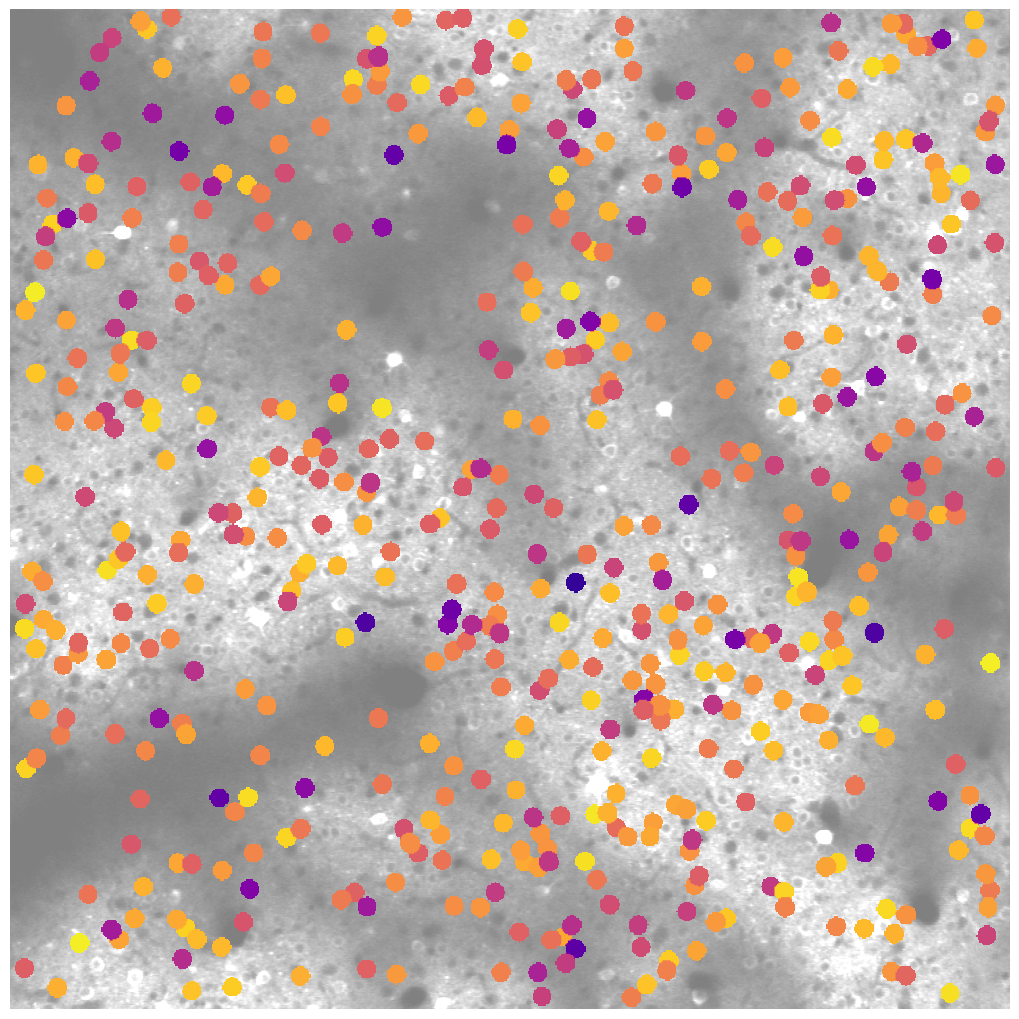

In [361]:
# get the indices of the cells with osi > 0.5
osi_threshold = 0.0
tuned_cells = cell_properties_df[cell_properties_df['osi'] > osi_threshold].index

# Load the stat and ops files from the current folder
stat = np.load(activity_path + r'\stat.npy', allow_pickle=True)
ops = np.load(activity_path + r'\ops.npy', allow_pickle=True).item()

im = np.zeros((ops['Ly'], ops['Lx']))

# # get cells which osi > 0.5
tuned_cells = cell_properties_df[cell_properties_df['osi'] > osi_threshold].index
tuned_cells_id = cell_properties_df.loc[tuned_cells, 'cell_id'].values


if len(tuned_cells_id) > 0:
    for cell in tuned_cells_id:
        ypix = stat[cell]['ypix'][~stat[cell]['overlap']]
        xpix = stat[cell]['xpix'][~stat[cell]['overlap']]
        # find the index of the cell in the cell_properties_df
        cell_index = np.where(cell_properties_df['cell_id'] == cell)[0][0]
        osi = cell_properties_df.loc[cell_index, 'osi']

        # Calculate the center of the cell
        center_y = np.mean(ypix)
        center_x = np.mean(xpix)
        
        # Create a circle mask with radius 10
        y, x = np.ogrid[:ops['Ly'], :ops['Lx']]
        dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        circle_mask = dist_from_center <= 8
        
        # Add the circle to the image
        im[circle_mask] = osi  # Set pixels inside the circle to 1
    

mean_img = ops['meanImg']
vmin = np.percentile(mean_img, 1)
vmax = np.percentile(mean_img, 99)

# Create the figure for display
plt.figure(figsize=(10, 10))
plt.imshow(ops['refImg'], alpha=0.5, cmap='gray', vmin=vmin, vmax=vmax)
# Create a mask for non-zero values
mask = im > 0
# Create a masked array where zeros are masked out
masked_im = np.ma.masked_where(im == 0, im)
plt.imshow(masked_im, alpha=1, vmin=0, vmax=1, cmap='plasma')
plt.axis('off')  # Turn off axes
plt.tight_layout(pad=0)  # Remove padding
plt.show()

# Create a new figure specifically for saving
fig = plt.figure(figsize=(10, 10))
plt.imshow(ops['refImg'], alpha=0.5, cmap='gray', vmin=vmin, vmax=vmax)
plt.imshow(masked_im, alpha=1, vmin=0, vmax=1, cmap='plasma')
plt.axis('off')  # Turn off axes
plt.tight_layout(pad=0)  # Remove padding
# Save the figure before showing it
plt.savefig(os.path.join(results_path, r'osi_map.png'), bbox_inches='tight', pad_inches=0, dpi=300)
plt.close(fig)  # Close the figure to free memory
